<h1>
<font color="#ff2e2e">
Mask Overlay
</font>
</h1>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib

<h3><font color = "#079e05"> This function is used to plot your result </font></h3>

In [ ]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

<h3><font color = "#079e05"> Complete put_mask function </font></h3>

In [51]:
def put_mask(face_img, mask_img):
    '''
    Adds mask image on face image.

    Parameters:
        face_img (numpy.ndarray): face image.
        mask_img (numpy.ndarray): mask image.
    
    Returns:
        numpy.ndarray: The result image.
    '''

    # Create a detector object using dlib's frontal face detector
    detector = dlib.get_frontal_face_detector()

    # Path to the file that contains facial landmark points
    predictor_path = 'shape_predictor_68_face_landmarks.dat'

    # Create a predictor object
    predictor = dlib.shape_predictor(predictor_path)

    # Detect the face from the face image
    face_rect = detector(face_img, 1)[0]

    # Get the 68 facial landmark points using the predictor object
    landmarks = predictor(face_img, face_rect)

    # Select the points corresponding to the nose, left cheek, right cheek, and chin
    nose = landmarks.part(30)
    left_cheek = landmarks.part(3)
    right_cheek = landmarks.part(13)
    chin = landmarks.part(8)

    # Store the selected points as a numpy array
    face_points = np.array([(left_cheek.x, left_cheek.y),
                            (right_cheek.x, right_cheek.y),
                            (chin.x, chin.y),
                            (nose.x, nose.y)],
                            np.float32)

    # Define the coordinates of the mask image's four corner points
    mask_points = np.array([(74, 314),
                            (1005, 343),
                            (609, 662),
                            (615, 212)],
                            np.float32)

    # Get projective matrix using the face and mask points
    matrix = cv2.getPerspectiveTransform(mask_points, face_points)

    # Apply the projective matrix to the mask image to match it to the face image's perspective
    mask_warped = cv2.warpPerspective(mask_img, matrix, (face_img.shape[1], face_img.shape[0]), None, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    # Convert the warped mask image to grayscale and threshold it
    mask_gray = cv2.cvtColor(mask_warped, cv2.COLOR_BGR2GRAY)
    _, mask_thresh = cv2.threshold(mask_gray, 10, 255, cv2.THRESH_BINARY)

    # Convert the thresholded mask image to RGB
    mask_rgb = cv2.cvtColor(mask_thresh, cv2.COLOR_GRAY2RGB)

    # Apply the mask where the mask is not empty
    result = cv2.bitwise_and(face_img, cv2.bitwise_not(mask_rgb))
    mask_warped_masked = cv2.bitwise_and(mask_warped, mask_rgb)

    # Add the masked warped mask image to the original face image
    result = cv2.add(result, mask_warped_masked)

    # Return the final result image
    return result


<h3><font color = "#079e05"> Show the result </font></h3>

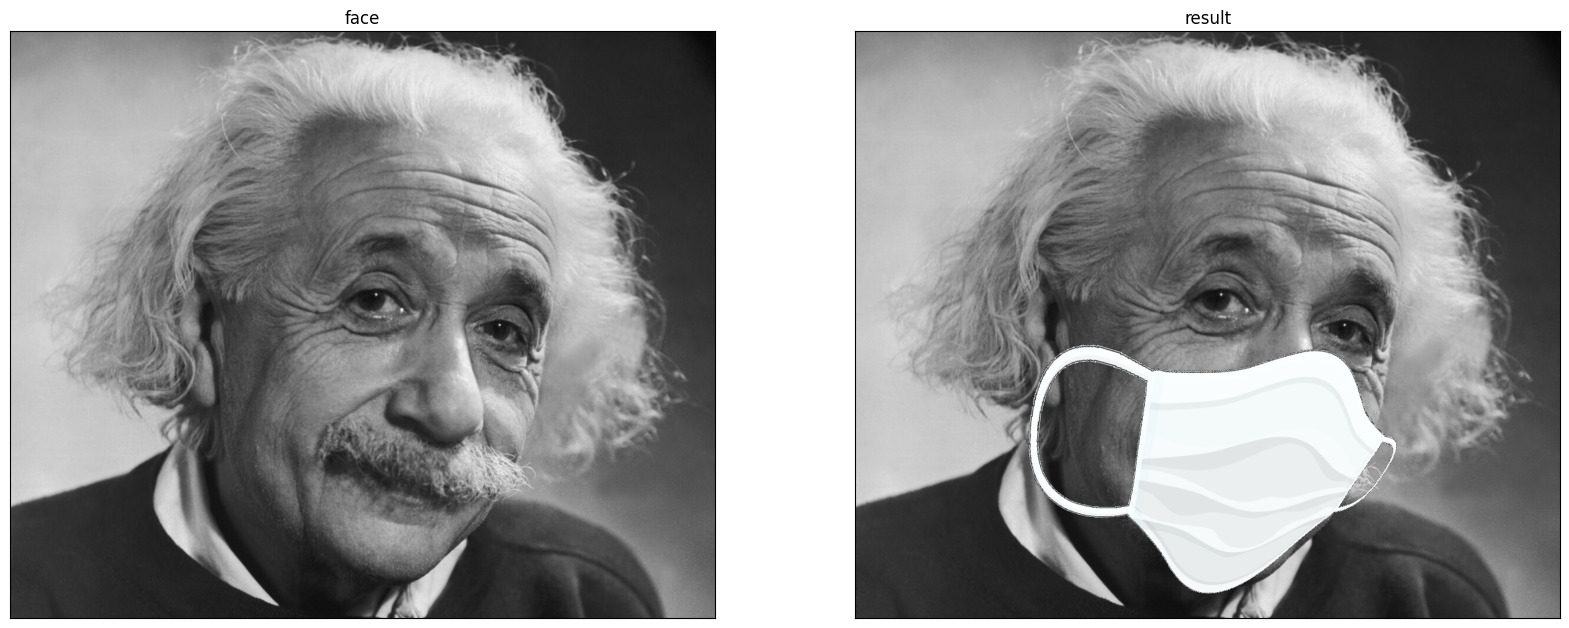

In [52]:
image_list = []
face = cv2.cvtColor(cv2.imread(os.path.join('/content', 'face.jpg')), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(os.path.join('/content', 'mask.jpg')), cv2.COLOR_BGR2RGB)
image_list.append([face, 'face', 'img'])
image_list.append([put_mask(face, mask), 'result', 'img'])
plotter(image_list, 1, 2, True, 20, 10, '3')